<a href="https://colab.research.google.com/github/poliduckie/poliduckie_segmentation/blob/master/examples/MPC_with_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
branch = "daffy" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
  !pip install pyglet==1.5.15
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

!pip install poliduckie-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.5 MB/s 
     |████████████████████████████████| 966 kB 14.3 MB/s 
     |████████████████████████████████| 49.5 MB 1.8 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 99 kB 10.6 MB/s 
     |████████████████████████████████| 61 kB 305 kB/s 
     |████████████████████████████████| 1.2 MB 56.1 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 660 kB 64.0 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 171 kB 72.2 MB/s 
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
     |████████████████████████████████| 210 kB 70.5 MB/s 
     |████████████████████████████████| 190 kB 68.7 

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.39 path /usr/local/lib/python3.7/dist-packages
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/contracts/library/array_ops.py:225: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.in

{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'headless': False, 'headless_device': 0}
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.2 MB 1.3 MB/s 
     |████████████████████████████████| 34.2 MB 1.3 MB/s 


In [2]:
# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [3]:
map_name = "Duckietown-ETH_large_loop"

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:602: UserWarning: WARN: Using the latest versioned environment `Duckietown-ETH_large_loop-v0` instead of the unversioned environment `Duckietown-ETH_large_loop`.
  f"Using the latest versioned environment `{new_env_id}` "
INFO:duckietown_world: data: /usr/local/lib/python3.7/dist-packages/duckietown_world/data
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:64: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  "Function `rng.randint(low, [high, size, dtype])` is marked as deprecated "
/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: I

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed a

(480, 640, 3)


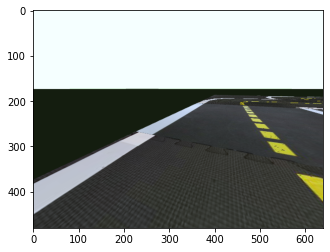

In [5]:
img_example = env.reset()
plt.imshow(img_example)
print(img_example.shape)

In [6]:
from poliduckie_segmentation import Segmentation
from poliduckie_segmentation import BirdEyeView
from skimage.transform import resize

segmentation = Segmentation()

birdeye = BirdEyeView()

img_axample = birdeye.computeBirdEye(img_example)
img_example = np.delete(img_example, [False, False, False, True], axis=-1)
img_example = resize(img_example, (img_example.shape[0],240, 320, 3), mode='constant', preserve_range='true')
        
prediction = segmentation.predict(img_example)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

NameError: ignored

In [ ]:
prediction_reshaped = np.reshape(prediction, (240, 320))
plt.imshow(prediction_reshaped)

In [ ]:
prediction_rounded = np.around(prediction_reshaped)

x = np.nan
while x is np.nan:
  y = 150
  x = np.argwhere(prediction_rounded[y]).mean()
  y -= 1

plt.scatter(x,y)
plt.imshow(prediction_rounded)

In [ ]:
lane_width = 0.445 # m
x_factor = lane_width/prediction_rounded.shape[1] # m/px
x_factor

In [ ]:
x_cm = x*x_factor
y_cm = 0.1 # m, needs to be tuned

In [ ]:
def get_reference_from_segmentation(img, x_factor=0.00139, y_cm=0.1, N=10):
  y = 150
  x = np.argwhere(prediction_rounded[y]).mean()
  x_cm = x*x_factor
  return np.array([[x_cm, y_cm]]*N).T

In [ ]:
from poliduckie_segmentation.control import MPC
M = MPC()

In [ ]:
r = get_reference_from_segmentation(prediction_rounded, N=11)

f"Reference is {r[0, 0], r[1,0]}"

In [ ]:
from poliduckie_segmentation.model import Model

# State X = [x, y, angle, longitudinal speed, angular speed]
X = [0,0,0,0,0]

F = Model()
input_list = []
positions = []

counter = 0

while np.square(X[0]-r[0,0]) + np.square(X[1]-r[1,0]) > 0.001 and counter < 20:
  action = M.mpc(X, r)
  if counter > 0:
    state = X.toarray().T[0]
  else:
    state = X
  X = F.step(*state, action)
  input_list.append(action)
  positions.append(X[:2])

  counter += 1

input_list = np.array(input_list)
positions = np.array(positions)

In [ ]:
input_list

In [ ]:
input_list_clipped = np.clip(input_list, 0, 1)

In [ ]:
plt.plot(input_list)

In [ ]:
positions.reshape(-1,2)

In [ ]:
plt.plot(*positions.reshape(-1, 2).T)

In [ ]:
img_frames = []
for action in input_list_clipped:
  env.step(action)
  img_frames.append(env.render(mode='rgb_array'))

In [ ]:
plt.imshow(img_frames[-1])

In [ ]:
import imageio
from IPython.display import Image

imageio.mimsave('mpc.gif', img_frames)
Image(open('mpc.gif','rb').read())

## Now multiple inputs

In [ ]:
# https://stackoverflow.com/questions/47910681/tensorflow-setting-allow-growth-to-true-does-still-allocate-memory-of-all-my-gp
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
img = env.reset()
img_frames = []
action_list = []

X = [0,0,0,0,0]
for iteration in range(50):
  img = birdeye.computeBirdEye(img)
  img = np.delete(img, [False, False, False, True], axis=-1)
  img = resize(img, (240, 320, 3), mode='constant', preserve_range='true')
  prediction = segmentation.predict(img)
  prediction_reshaped = np.reshape(prediction, (240, 320))
  prediction_rounded = np.around(prediction_reshaped)
  r = get_reference_from_segmentation(prediction_rounded, N=11)
  if iteration > 0:
    state = X.toarray().T[0]
  else:
    state = X
  action = M.mpc(state, r)
  X = F.step(*state, action)
  env.step(action)
  action_list.append(action)
  img = cv2.resize(img,(320,240),interpolation=cv2.INTER_CUBIC)
  img = cv2.circle(img, (int(r[0,0]/0.001390625), 120), 10, color=(0, 0, 255), thickness=-1)
  img_frames.append(img)
  img = env.render(mode='rgb_array')
  

In [ ]:
imageio.mimsave('run_mpc.gif', img_frames)
Image(open('run_mpc.gif','rb').read())

In [ ]:
action_list